In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shatish2403","key":"e5010a48864b7d2df3a89703aca31ac6"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # Make sure you've uploaded this file first
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install kaggle

In [4]:
!kaggle competitions download -c aptos2019-blindness-detection

User cancelled operation


In [5]:
!unzip aptos2019-blindness-detection.zip -d aptos2019

unzip:  cannot find or open aptos2019-blindness-detection.zip, aptos2019-blindness-detection.zip.zip or aptos2019-blindness-detection.zip.ZIP.


In [59]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import types
from timm.models.swin_transformer_v2 import WindowAttention

# Load the model and modify image size if needed
swin_model = timm.create_model('swinv2_tiny_window8_256', pretrained=True)
swin_model.patch_embed.img_size = (224, 224)
swin_model.patch_embed.strict_img_size = False

# Move model to device first
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
swin_model = swin_model.to(device)

# Find all WindowAttention instances in the model
for name, module in swin_model.named_modules():
    if isinstance(module, WindowAttention):
        # Add uncertainty branch to this module instance
        module.uncertainty_branch = nn.Sequential(
            nn.LayerNorm(module.dim),
            nn.Linear(module.dim, module.num_heads),
            nn.Sigmoid()
        ).to(device)  # Move to same device as model

        # Define the new forward method
        def new_forward(self, x, mask=None):
            # Call the original forward up to the softmax
            B_, N, C = x.shape
            qkv_bias = None
            if self.q_bias is not None:
                qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
            qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
            qkv = qkv.reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]

            # cosine attention
            attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
            # FIX: Create tensor on same device as model
            max_value = torch.log(torch.tensor(1. / 0.01, device=x.device))
            logit_scale = torch.clamp(self.logit_scale, max=max_value).exp()
            attn = attn * logit_scale

            relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
            relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
            relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
            attn = attn + relative_position_bias.unsqueeze(0)

            if mask is not None:
                nW = mask.shape[0]
                attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
                attn = attn.view(-1, self.num_heads, N, N)
                attn = self.softmax(attn)
            else:
                attn = self.softmax(attn)

            # SRA: Compute uncertainty scores and modulate attention
            uncertainty_scores = self.uncertainty_branch(x)  # (B_, N, num_heads)
            uncertainty_scores = uncertainty_scores.permute(0, 2, 1)  # (B_, num_heads, N)

            # Rescale to range [0.5, 1.5] to allow both enhancement and suppression
            uncertainty_factors = uncertainty_scores * 1.0 + 0.5

            # Reshape for broadcasting
            uncertainty_factors = uncertainty_factors.unsqueeze(-1)  # (B_, num_heads, N, 1)

            # Apply the scaling factors to attention weights
            attn = attn * uncertainty_factors

            attn = self.attn_drop(attn)

            x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
            x = self.proj(x)
            x = self.proj_drop(x)
            return x

        # Replace the forward method
        module.forward = types.MethodType(new_forward, module)

print(f"SRA enhancement applied to {swin_model.__class__.__name__} on {device}")

SRA enhancement applied to SwinTransformerV2 on cuda:0


In [60]:
swin_model.load_state_dict(torch.load('swin_sra_final_model.pth',map_location=torch.device('cpu')))
swin_model.eval()

SwinTransformerV2(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerV2Stage(
      (downsample): Identity()
      (blocks): ModuleList(
        (0): SwinTransformerV2Block(
          (attn): WindowAttention(
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
            (qkv): Linear(in_features=96, out_features=288, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
            (uncertainty_branch): Sequential(
              (0): LayerNorm((96,), eps=1e-05, elementwise_affine=Tr

Predicted Class: 3, Confidence: 1.0000

=== Computing SHAP Values (Memory Optimized) ===

SHAP values shape: (3, 256, 256, 1)

=== Generating Enhanced Visualizations ===


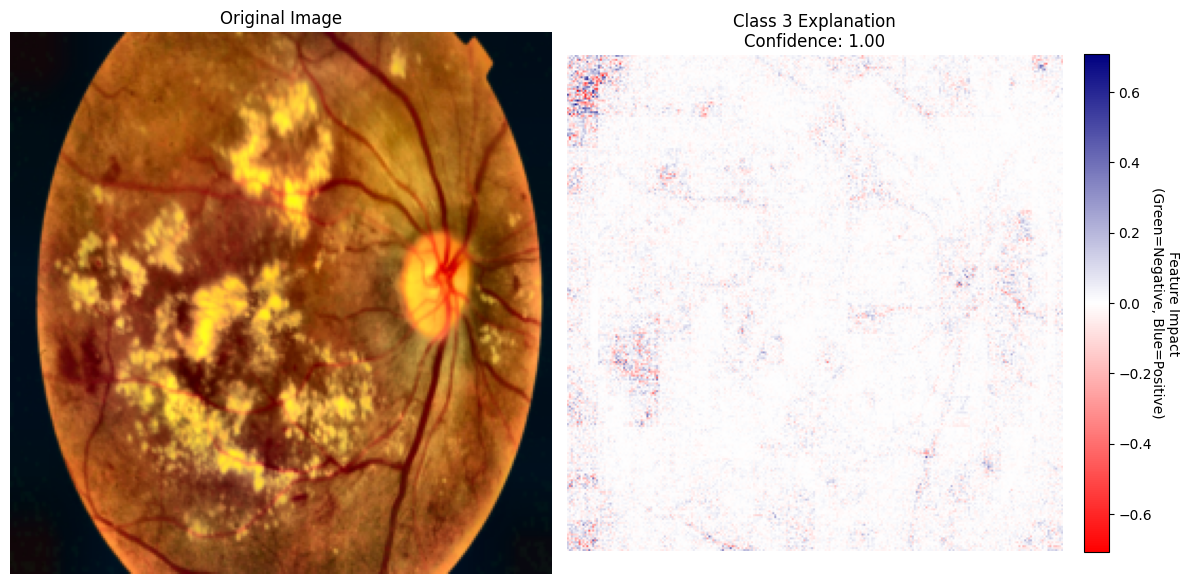

In [49]:
import shap
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# --------------- Image Preprocessor Class ---------------
class ImagePreprocessor:
    def __init__(self, clip_limit_l=5.0, clip_limit_ab=1.5, tile_grid_size=(8, 8), gamma_scale=1.2):
        self.clip_limit_l = clip_limit_l
        self.clip_limit_ab = clip_limit_ab
        self.tile_grid_size = tile_grid_size
        self.gamma_scale = gamma_scale
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe_l = cv2.createCLAHE(clipLimit=self.clip_limit_l, tileGridSize=self.tile_grid_size)
        clahe_ab = cv2.createCLAHE(clipLimit=self.clip_limit_ab, tileGridSize=self.tile_grid_size)
        l_clahe = clahe_l.apply(l)
        a_clahe = clahe_ab.apply(a)
        b_clahe = clahe_ab.apply(b)
        lab_clahe = cv2.merge((l_clahe, a_clahe, b_clahe))
        return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    def adaptive_gamma_correction(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray) / 255.0
        gamma = np.clip(1.0 + (self.gamma_scale - 1.0) * (0.5 - mean_intensity), 0.5, 2.0) if mean_intensity > 0 else 1.0
        lookup_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype('uint8')
        return cv2.LUT(image, lookup_table)

    def preprocess(self, image):
        img_gamma = self.adaptive_gamma_correction(image)
        img_clahe = self.apply_clahe(img_gamma)
        img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        return self.transform(img_pil)

# --------------- Setup and Model Loading ---------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your model here (replace with your actual model loading)
# swin_model = YourModelClass()
# swin_model.load_state_dict(torch.load("swin_sra_final_model.pth", map_location=device))
swin_model.eval()
swin_model.to(device)

# --------------- Image Processing ---------------
preprocessor = ImagePreprocessor()
image_path = "0f96c358a250.png"
image = cv2.imread(image_path)
input_tensor = preprocessor.preprocess(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    output = swin_model(input_tensor)
    probs = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = torch.max(probs).item()

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

# --------------- SHAP Explanation (Final Robust Version) ---------------
# --------------- Memory-Efficient SHAP Explanation ---------------
print("\n=== Computing SHAP Values (Memory Optimized) ===")

# 1. Reduce batch size and use simpler background
background = torch.zeros(2, 3, 256, 256, device=device)  # Just black images

# 2. Create explainer with smaller batch size
explainer = shap.GradientExplainer(
    model=swin_model,
    data=background,
    batch_size=1  # Reduce batch size to save memory
)

# 3. Compute SHAP values for just the predicted class
with torch.enable_grad():
    # Only compute for the predicted class to save memory
    shap_values = explainer.shap_values(
        input_tensor,
        ranked_outputs=1,  # Only compute for top class
        output_rank_order='max'  # Get explanation for max class
    )

# 4. Process SHAP values with memory efficiency
if isinstance(shap_values, tuple):
    shap_values = shap_values[0]  # Unpack (values, indexes)

if isinstance(shap_values, list):
    # Convert list to numpy array
    shap_np = np.array([sv.cpu().numpy() if torch.is_tensor(sv) else sv for sv in shap_values])
    shap_np = shap_np[0]  # Get first (and only) input
else:
    shap_np = shap_values[0].cpu().numpy() if torch.is_tensor(shap_values) else shap_values[0]

print(f"\nSHAP values shape: {shap_np.shape}")

# 5. Memory-efficient visualization
# --------------- Improved SHAP Visualization ---------------
print("\n=== Generating Enhanced Visualizations ===")

# Prepare image
input_image_vis = input_tensor.squeeze(0).detach().cpu().numpy()
input_image_vis = np.transpose(input_image_vis, (1, 2, 0))  # CHW→HWC
input_image_vis = (input_image_vis * 127.5 + 127.5).clip(0, 255).astype(np.uint8)

# Process SHAP values
shap_heatmap = np.sum(shap_np, axis=0)  # Sum across color channels

# Normalize SHAP values for visualization
max_val = max(abs(shap_heatmap.min()), abs(shap_heatmap.max()))
norm = plt.Normalize(vmin=-max_val, vmax=max_val)

# --------------- Green-Blue SHAP Visualization ---------------
from matplotlib.colors import LinearSegmentedColormap

# Create custom green-to-blue colormap
colors = [(0, "red"), (0.5, "white"), (1, "navy")]
green_blue_cmap = LinearSegmentedColormap.from_list("red_blue", colors)

# Prepare visualization
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image_vis)
plt.title('Original Image')
plt.axis('off')

# SHAP overlay with new color scheme
plt.subplot(1, 2, 2)
plt.imshow(input_image_vis)

# Normalize SHAP values (green = negative impact, blue = positive impact)
abs_max = max(abs(shap_heatmap.min()), abs(shap_heatmap.max()))
im = plt.imshow(
    shap_heatmap,
    cmap=green_blue_cmap,
    alpha=1,
    vmin=-abs_max,
    vmax=abs_max
)

# Add colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Feature Impact\n(Green=Negative, Blue=Positive)', rotation=270, labelpad=20)

plt.title(f'Class {predicted_class} Explanation\nConfidence: {confidence:.2f}')
plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB

[INFO] GradCAM saved to gradcam_output.jpg


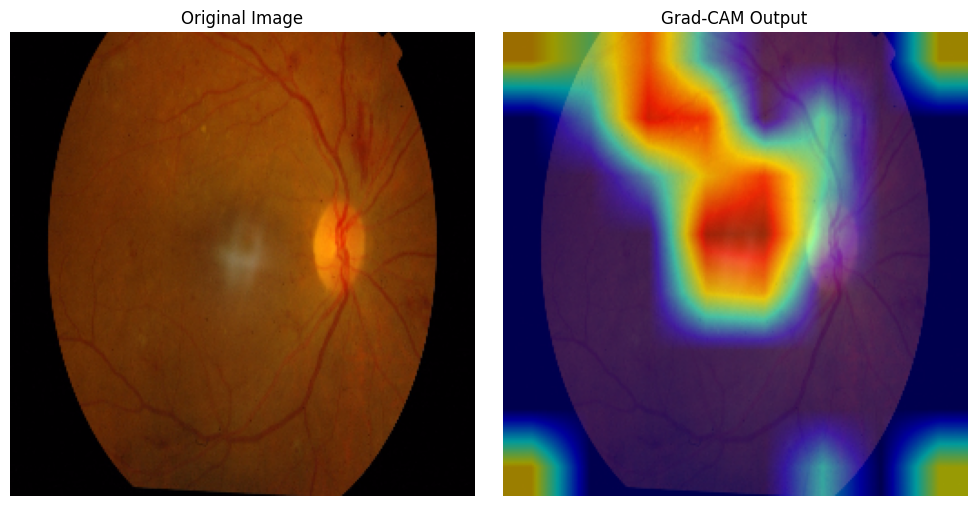

In [68]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import matplotlib.pyplot as plt

# === Variables ===
image_path = '0c7e82daf5a0.png'       # 👈 your image path
model_path = 'swin_sra_final_model.pth'   # 👈 your saved Swin model
save_path = 'gradcam_output.jpg'

# === Reshape transform (for Swin Transformers) ===
def reshape_transform(tensor, height=8, width=8):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# === Load your Swin model ===

swin_model.eval()
if torch.cuda.is_available():
    swin_model = swin_model.cuda()

# === Target layer (final normalization layer in last Swin block) ===
target_layers = [swin_model.layers[-1].blocks[-1].norm2]

# === GradCAM without use_cuda ===
cam = GradCAM(model=swin_model,
              target_layers=target_layers,
              reshape_transform=reshape_transform)

# === Load and preprocess image ===
rgb_img = cv2.imread(image_path)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (256, 256))
rgb_img = np.float32(rgb_img) / 255.0

input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
if torch.cuda.is_available():
    input_tensor = input_tensor.cuda()

# === Generate GradCAM ===
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# === Save result ===
cv2.imwrite(save_path, cam_image)
print(f"[INFO] GradCAM saved to {save_path}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(rgb_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(cam_image)
axs[1].set_title("Grad-CAM Output")
axs[1].axis('off')

plt.tight_layout()
plt.show()
